**Content Disclaimer**: This dataset contains real title posts scraped from the r/depression subreddit, and some of the titles contain language that is not safe for work, crude, or offensive. The full dataset is available as `depression.csv`, `preprocessed_thoughts.csv`, `thoughts.csv`, and `token_df.csv`. Unfortunately, I did not provide a sanitized version of my dataset because the words contained were important for the analysis and understanding of the model. Please note that the model, the dataset, and the techniques used are not perfect. If you have any concerns about working with this dataset, looking at my analysis, or the topic in general, you can skip my content overall or click [here](http://iamsorry.com/).

# Modeling Notebook

# Imports

In [53]:
import p3_tools as p3t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # for plotting
from sklearn.naive_bayes import MultinomialNB # Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # transforming
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier # Classification Problem
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier


from nltk.corpus import stopwords, words

In [7]:
pwd

'N:\\Documents\\General-Assembly\\dsi-cc13\\projects\\project_3\\deliverables'

In [20]:
thoughts = pd.read_csv('saved_data/preprocessed_thoughts.csv')

Added words may or may not be added to stopwords in models provided.

In [3]:
add_words = ['depression','shower thoughts','shower','thoughts'] 
# reason for these words is due to the fact that they are the name of the subreddits
# there could be possible short hands.
more_stopwords = stopwords.words('english') + add_words
more_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
X = thoughts['title']
y = thoughts['subreddit']
X.shape, y.shape

((20000,), (20000,))

# Baseline score

---
Since we need a baseline, all of our true y values would be used to determined our baseline accuracy. Since we have almost equal representation of `depression` and `shower thoughts`, our baseline is around 50%.

In [5]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

Quick baseline on our `y_test`

In [9]:
y_test.value_counts(normalize=True)

1    0.502424
0    0.497576
Name: subreddit, dtype: float64

The goal to beat is more than 50%

# Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.33,
                                                    random_state=66)

In [23]:
X_train.shape, y_train.shape

((13400,), (13400,))

In [24]:
X_test.shape, y_test.shape

((6600,), (6600,))

# Model 1

Just to get started on modeling, this is my first benchmarks.

In [19]:
# cvec and multi
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {'cvec__max_features': [2000,3000,4000,5000],
              'cvec__min_df': [2,3],
              'cvec__max_df': [.9,.95],
              'cvec__ngram_range': [(1,1),(1,2)]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1)

gs.fit(X_train, y_train)

In [24]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [25]:
gs.best_score_

0.9102500000000001

In [26]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=3,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [27]:
gs.score(X_test, y_test)

0.914625

In [28]:
preds = gs.predict(X_test)

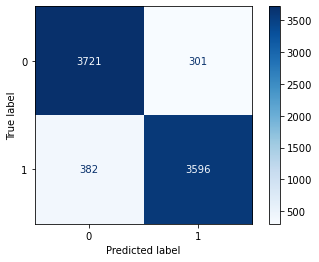

In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [32]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.925161611138737, 0.9039718451483157)

# Model 2

---
Here, I will use `TfidVectorizer` but with the same model and parameters. I want to see if that made a difference.

In [45]:
# tfid and multi
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {'tvec__max_features': [2000,3000,4000,5000],
              'tvec__min_df': [2,3],
              'tvec__max_df': [.9,.95],
              'tvec__ngram_range': [(1,1),(1,2)]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1)

In [48]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   33.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [49]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [50]:
gs.best_score_

0.9096666666666666

In [51]:
gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [56]:
gs.score(X_train, y_train)

0.93375

In [52]:
gs.score(X_test, y_test)

0.914625

In [53]:
preds = gs.predict(X_test)

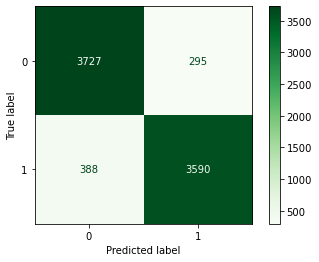

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [55]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.9266534062655395, 0.9024635495223731)

# Many, many models

---
Will implement a function that takes in an empyt dataframe and adds all results to it. It will take in the best parameters, best estimator, best score, train and test scores, a list of the predictions, the classification metrics, and specificity & sensitivity.

## Tfid and LogReg

In [32]:
# tfid and logreg
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', LogisticRegression())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2']}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   21.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   47.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 10.2min
[Parallel(n_jobs=2)]: Done 6000 out of 6000 | elapsed: 12.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=2,
             param_grid={'model__penalty': ['l1', 'l2'],
                         'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [33]:
gs.best_params_

{'model__penalty': 'l2',
 'trans__max_df': 0.85,
 'trans__max_features': 4000,
 'trans__min_df': 5,
 'trans__ngram_range': (1, 3),
 'trans__stop_words': None}

In [34]:
gs.best_score_

0.9143283582089552

In [35]:
gs.best_estimator_

Pipeline(steps=[('trans',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=5,
                                 ngram_range=(1, 3))),
                ('model', LogisticRegression())])

In [36]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9382089552238806, 0.9224242424242424)

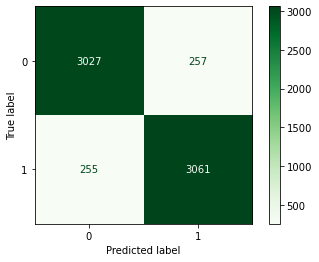

In [37]:
preds = gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [38]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.9217417783191231, 0.9231001206272618)

# Cvec and Multi

In [39]:
# cvec and multi
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {'cvec__max_features': [2000,3000,4000,5000,6000],
              'cvec__min_df': [2,3,4,5],
              'cvec__max_df': [.85,.9,.95],
              'cvec__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'cvec__stop_words': ['english', None]}


gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 11.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                               (3, 3)],
                         'cvec__stop_words': ['english', None]},
             verbose=1)

In [40]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 6000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [41]:
gs.best_score_

0.9071641791044776

In [42]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=6000, min_df=2)),
                ('nb', MultinomialNB())])

In [43]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9313432835820895, 0.9195454545454546)

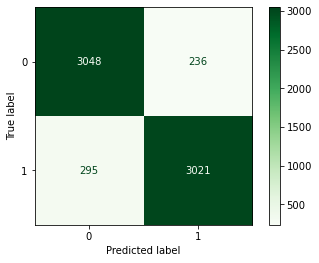

In [44]:
preds = gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [45]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.928136419001218, 0.911037394451146)

# Tfid and Multi

In [15]:
# tfid and multi
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', MultinomialNB())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   54.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  5.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=2,
             param_grid={'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [16]:
gs.best_params_

{'trans__max_df': 0.85,
 'trans__max_features': 6000,
 'trans__min_df': 2,
 'trans__ngram_range': (1, 1),
 'trans__stop_words': None}

In [17]:
gs.best_score_

0.9064925373134329

In [18]:
gs.best_estimator_

Pipeline(steps=[('trans',
                 TfidfVectorizer(max_df=0.85, max_features=6000, min_df=2)),
                ('model', MultinomialNB())])

In [19]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9373134328358209, 0.9143939393939394)

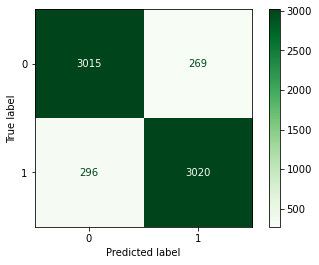

In [20]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [21]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.9180876979293544, 0.9107358262967431)

# Cvec and Logreg

Best model so far...


In [27]:
# cvec and logreg
pipe = Pipeline([
    ('trans', CountVectorizer()),
    ('model', LogisticRegression())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2']}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   39.2s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1588 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 2488 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 3588 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 4362 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 5112 tasks      | elapsed: 11.1min
[Parallel(n_jobs=2)]: Done 5962 tasks      | elapsed: 13.4min
[Parallel(n_jobs=2)]: Done 6000 out of 6000 | elapsed: 13.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans', CountVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=2,
             param_grid={'model__penalty': ['l1', 'l2'],
                         'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [28]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__penalty': 'l2',
  'trans__max_df': 0.85,
  'trans__max_features': 6000,
  'trans__min_df': 2,
  'trans__ngram_range': (1, 2),
  'trans__stop_words': None},
 0.9164925373134329,
 Pipeline(steps=[('trans',
                  CountVectorizer(max_df=0.85, max_features=6000, min_df=2,
                                  ngram_range=(1, 2))),
                 ('model', LogisticRegression())]))

In [29]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9664925373134329, 0.9275757575757576)

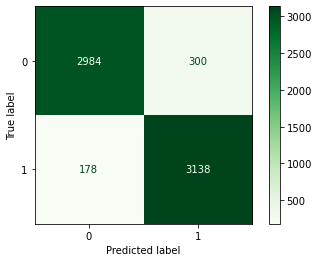

In [30]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [31]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.9086479902557856, 0.9463208685162847)

### Wanted to incorporate my own stopwords

In [52]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {'cvec__max_features': [2000,3000,4000,5000,6000],
              'cvec__min_df': [2,3,4,5],
              'cvec__max_df': [.85,.9,.95],
              'cvec__ngram_range': [(1,1),(1,2)],
              'cvec__stop_words': ['english', more_stopwords]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself',

In [53]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'cvec__max_df': 0.85,
  'cvec__max_features': 6000,
  'cvec__min_df': 2,
  'cvec__ngram_range': (1, 2),
  'cvec__stop_words': ['i',
   'me',
   'my',
   'myself',
   'we',
   'our',
   'ours',
   'ourselves',
   'you',
   "you're",
   "you've",
   "you'll",
   "you'd",
   'your',
   'yours',
   'yourself',
   'yourselves',
   'he',
   'him',
   'his',
   'himself',
   'she',
   "she's",
   'her',
   'hers',
   'herself',
   'it',
   "it's",
   'its',
   'itself',
   'they',
   'them',
   'their',
   'theirs',
   'themselves',
   'what',
   'which',
   'who',
   'whom',
   'this',
   'that',
   "that'll",
   'these',
   'those',
   'am',
   'is',
   'are',
   'was',
   'were',
   'be',
   'been',
   'being',
   'have',
   'has',
   'had',
   'having',
   'do',
   'does',
   'did',
   'doing',
   'a',
   'an',
   'the',
   'and',
   'but',
   'if',
   'or',
   'because',
   'as',
   'until',
   'while',
   'of',
   'at',
   'by',
   'for',
   'with',
   'about',
   'against',
   'betwe

In [54]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8973134328358209, 0.8613636363636363)

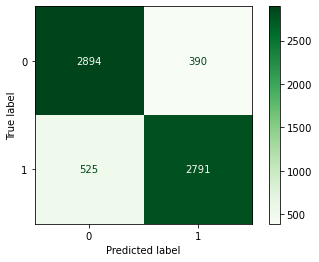

In [55]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [56]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.8812423873325214, 0.8416767189384801)

In [57]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {'tfid__max_features': [2000,3000,4000,5000,6000],
              'tfid__min_df': [2,3,4,5],
              'tfid__max_df': [.85,.9,.95],
              'tfid__ngram_range': [(1,1),(1,2)],
              'tfid__stop_words': ['english', more_stopwords]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   45.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:  2.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'tfid__max_df': [0.85, 0.9, 0.95],
                         'tfid__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tfid__min_df': [2, 3, 4, 5],
                         'tfid__ngram_range': [(1, 1), (1, 2)],
                         'tfid__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself',

In [58]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'tfid__max_df': 0.85,
  'tfid__max_features': 6000,
  'tfid__min_df': 2,
  'tfid__ngram_range': (1, 2),
  'tfid__stop_words': ['i',
   'me',
   'my',
   'myself',
   'we',
   'our',
   'ours',
   'ourselves',
   'you',
   "you're",
   "you've",
   "you'll",
   "you'd",
   'your',
   'yours',
   'yourself',
   'yourselves',
   'he',
   'him',
   'his',
   'himself',
   'she',
   "she's",
   'her',
   'hers',
   'herself',
   'it',
   "it's",
   'its',
   'itself',
   'they',
   'them',
   'their',
   'theirs',
   'themselves',
   'what',
   'which',
   'who',
   'whom',
   'this',
   'that',
   "that'll",
   'these',
   'those',
   'am',
   'is',
   'are',
   'was',
   'were',
   'be',
   'been',
   'being',
   'have',
   'has',
   'had',
   'having',
   'do',
   'does',
   'did',
   'doing',
   'a',
   'an',
   'the',
   'and',
   'but',
   'if',
   'or',
   'because',
   'as',
   'until',
   'while',
   'of',
   'at',
   'by',
   'for',
   'with',
   'about',
   'against',
   'betwe

In [59]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9044029850746269, 0.8610606060606061)

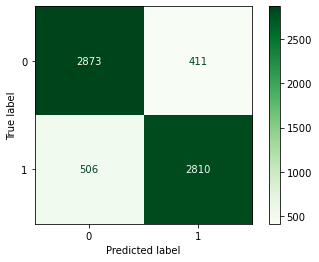

In [60]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [61]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.8748477466504263, 0.8474065138721351)

# Random Forest Models

In order to cover all basis of modeling, I will be doing a RandomForest model as well as ExtraTree model.

---
First practice model.

In [8]:
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', RandomForestClassifier(random_state=66))
])

params = {
    'model__n_estimators':[75, 100, 125],
    'model__max_features': [None, 'auto'],
    'model__max_depth': [None, 5, 6]
}

gs = GridSearchCV(pipe, 
                  param_grid=params,
                  cv=5, verbose=1, n_jobs=2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  9.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model',
                                        RandomForestClassifier(random_state=66))]),
             n_jobs=2,
             param_grid={'model__max_depth': [None, 5, 6],
                         'model__max_features': [None, 'auto'],
                         'model__n_estimators': [75, 100, 125]},
             verbose=1)

In [9]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__max_depth': None,
  'model__max_features': 'auto',
  'model__n_estimators': 125},
 0.9048507462686567,
 Pipeline(steps=[('trans', TfidfVectorizer()),
                 ('model',
                  RandomForestClassifier(n_estimators=125, random_state=66))]))

In [10]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9984328358208955, 0.9072727272727272)

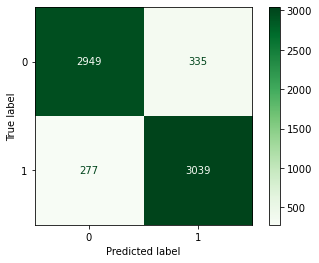

In [11]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [12]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.8979902557856273, 0.9164656212303981)

I wanna make a model that uses the same parameters as my best model but with a random forest model instead of a logistic regression.

---
After looking at the results, it is a much worse model that I could have expected. It is also overfitting like crazy.

In [41]:
# cvec and logreg

# what should be removed
# Max features can get rid of because already limiting

pipe = Pipeline([
    ('trans', CountVectorizer()),
    ('model', RandomForestClassifier())
])

pipe_params = {
              'trans__ngram_range': [(1,1),(2,2),(3,3)], # dont go too crazy
              'trans__stop_words': ['english', more_stopwords],
              'model__n_estimators':[100, 125],
              'model__max_depth': [None,3,4, 5, 6],
              'model__max_features':['auto','log2'],
#               'model__min_samples_splits': [2,3],
              'model__min_samples_leaf':[1,2],
}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=5)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  9.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  9.8min
[Parallel(n_jobs=5)]: Done 1200 out of 1200 | elapsed: 10.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans', CountVectorizer()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'model__max_depth': [None, 3, 4, 5, 6],
                         'model__max_features': ['auto', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__n_estimators': [100, 125],
                         'trans__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'trans__stop_words': ['english',
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'your

These results were from a really bad model.

In [42]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__max_depth': None,
  'model__max_features': 'log2',
  'model__min_samples_leaf': 2,
  'model__n_estimators': 125,
  'trans__ngram_range': (1, 1),
  'trans__stop_words': 'english'},
 0.8490298507462686,
 Pipeline(steps=[('trans', CountVectorizer(stop_words='english')),
                 ('model',
                  RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                                         n_estimators=125))]))

In [43]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8819402985074627, 0.850909090909091)

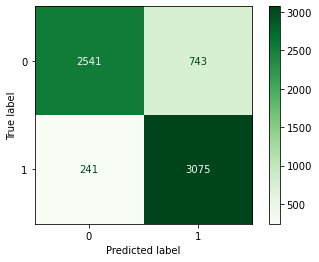

In [44]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [45]:
# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
spec, sen

(0.7737515225334958, 0.9273220747889023)

In [46]:
# Bust out the coefficients, feature importance
gs.best_estimator_.named_steps['trans'].get_feature_names()

['00',
 '000',
 '000001',
 '000gm',
 '001',
 '01',
 '06am',
 '09',
 '0x98a',
 '10',
 '100',
 '1000',
 '1000s',
 '1000th',
 '100k',
 '100mg',
 '100s',
 '100th',
 '100x',
 '100yrs',
 '101',
 '102',
 '107',
 '10km',
 '10mg',
 '10th',
 '10x',
 '11',
 '111111111',
 '112',
 '11pm',
 '11th',
 '12',
 '1200',
 '122',
 '12345678987654321',
 '13',
 '13yo',
 '14',
 '1400mg',
 '140p',
 '15',
 '1500',
 '15m',
 '15mg',
 '15mins',
 '15th',
 '15y',
 '16',
 '16f',
 '16th',
 '17',
 '1700s',
 '1776',
 '17m',
 '18',
 '180',
 '1800',
 '1800s',
 '1843',
 '1870',
 '19',
 '1920',
 '1940s',
 '1950s',
 '1955',
 '1969',
 '1970',
 '1979',
 '197b',
 '1984',
 '1985',
 '1989',
 '1990',
 '1990s',
 '1993',
 '1994',
 '1995',
 '19f',
 '19m',
 '1hr',
 '1k',
 '1mg',
 '1million',
 '1min',
 '1st',
 '1x10',
 '1y',
 '1yr',
 '20',
 '200',
 '2000',
 '2000s',
 '2001',
 '2002',
 '2004',
 '2005',
 '2006',
 '200mg',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2019',
 '2020',
 '2020ad',
 '2020s',
 '2021',
 '2022'

# Importing my stemmed words and running a model on it.

---
In the models here, instead of applying CountVectorizer (CVEC) and TfidVectorizer (TFID) on...
```python
thoughts['title']
```
and running a model on it. 

Now, I will import my own stemmed and lemmatized tokens, "token_df.csv" and run some models on them. The reason is because in this csv file, I had already tokenized them but had done nothing else on them. After performing a bit of EDA, the PorterStemmed words had a more significant difference from a normal CVEC/TFID on the title. The word "depress" made a big change in terms of how many times it appears meaning the other variants of it became stemmed to "depress". This adds more weight to the word as well decrease the number of columns/features for the model.
```python
thoughts2 = pd.read_csv('saved_data/token_df.csv')
```

---
My predictions: I think this may improve the model since we are grouping the words onto the root of the word. This can help reduce the number of features.

In [47]:
thoughts2 = pd.read_csv('saved_data/token_df.csv')

In [48]:
thoughts2.head()

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
0,0,0,[removed],Vampires and skeletons are just different type...,9,"['Vampires', 'and', 'skeletons', 'are', 'just'...",59,"['vampire', 'and', 'skeleton', 'are', 'just', ...","['vampir', 'and', 'skeleton', 'are', 'just', '...","{'are', 'just', 'of', 'and'}"
1,1,0,NaN,Life is actually a telltale game because the c...,13,"['Life', 'is', 'actually', 'a', 'telltale', 'g...",66,"['life', 'is', 'actually', 'a', 'telltale', 'g...","['life', 'is', 'actual', 'a', 'telltal', 'game...","{'to', 'a', 'you', 'is', 'up', 'are', 'the', '..."
2,2,0,[removed],Wouldn’t a botched circumcision just be a peni...,10,"['Wouldn', 't', 'a', 'botched', 'circumcision'...",53,"['wouldn', 't', 'a', 'botched', 'circumcision'...","['wouldn', 't', 'a', 'botch', 'circumcis', 'ju...","{'a', 't', 'just', 'be', 'wouldn'}"
3,3,0,NaN,You might of made a decision that saved your l...,13,"['You', 'might', 'of', 'made', 'a', 'decision'...",70,"['you', 'might', 'of', 'made', 'a', 'decision'...","['you', 'might', 'of', 'made', 'a', 'decis', '...","{'that', 'you', 'a', 'it', 'your', 'of'}"
4,4,0,[removed],"If you have ever opened the toilet water tank,...",24,"['If', 'you', 'have', 'ever', 'opened', 'the',...",116,"['if', 'you', 'have', 'ever', 'opened', 'the',...","['if', 'you', 'have', 'ever', 'open', 'the', '...","{'how', 'for', 'you', 'a', 'have', 'will', 'if..."


In [51]:
thoughts2.shape

(20000, 10)

In [49]:
# Get your X and Y
X_stem = thoughts2['pstem_words']
y_stem = thoughts2['subreddit']

In [50]:
y_stem.value_counts(normalize=True) # Same Baseline

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [52]:
X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(X_stem, y_stem,
                                                    test_size=.33,
                                                    random_state=66)

## CVEC and LogReg

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 14.2mi

0.9670149253731344 0.9324242424242424
Specificity: 0.9150426309378806 Sensitivity: 0.9496381182147166


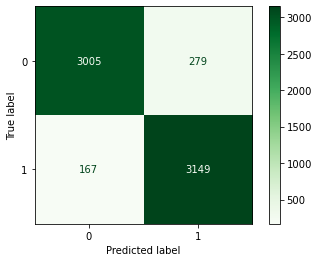

In [82]:
pipe = Pipeline([
    ('trans', CountVectorizer()),
    ('model', LogisticRegression())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2'],
              'model__C':[1,.95]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)
print(gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test))
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

In [83]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__C': 0.95,
  'model__penalty': 'l2',
  'trans__max_df': 0.85,
  'trans__max_features': 6000,
  'trans__min_df': 2,
  'trans__ngram_range': (1, 2),
  'trans__stop_words': None},
 0.9209701492537313,
 Pipeline(steps=[('trans',
                  CountVectorizer(max_df=0.85, max_features=6000, min_df=2,
                                  ngram_range=(1, 2))),
                 ('model', LogisticRegression(C=0.95))]))

---

In [102]:
pipe3 = Pipeline([
    ('trans', CountVectorizer()),
    ('model', LogisticRegression())
])

pipe_params3 = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2'],
              'model__C':[1,.95]}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs3 = GridSearchCV(pipe3,
                  pipe_params3,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs3.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3436 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 4086 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 4836 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 5686 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 6636 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 7686 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 8836 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 10086 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 11436 tasks      | elapsed: 15.4min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed: 1

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', CountVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=4,
             param_grid={'model__C': [1, 0.95], 'model__penalty': ['l1', 'l2'],
                         'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [103]:
gs3.best_params_, gs3.best_score_, gs3.best_estimator_

({'model__C': 0.95,
  'model__penalty': 'l2',
  'trans__max_df': 0.85,
  'trans__max_features': 6000,
  'trans__min_df': 3,
  'trans__ngram_range': (1, 3),
  'trans__stop_words': None},
 0.9193283582089551,
 Pipeline(steps=[('trans',
                  CountVectorizer(max_df=0.85, max_features=6000, min_df=3,
                                  ngram_range=(1, 3))),
                 ('model', LogisticRegression(C=0.95))]))

In [104]:
gs3.score(X_stem_train, y_stem_train), gs3.score(X_stem_test, y_stem_test)

(0.9658955223880596, 0.9316666666666666)

Specificity: 0.9147381242387332 Sensitivity: 0.9484318455971049


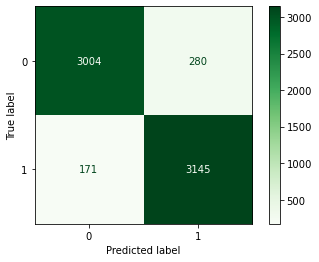

In [105]:
preds = gs3.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs3, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

I will pickle this model as well.

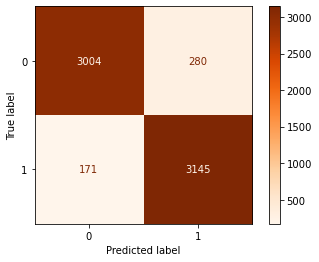

In [106]:
# pickle model
pickle.dump(gs3, open('./assets/another_model.pkl', 'wb+'))
# pickle confusion matrix
pickle.dump(plot_confusion_matrix(gs3, X_stem_test, y_stem_test, cmap='Oranges', values_format='d'), 
            open('./assets/another_confusionmatrix.pkl','wb+'))
# pickle train and test score
pickle.dump(gs3.score(X_stem_train, y_stem_train), open('./assets/another_train_score.pkl','wb+'))
pickle.dump(gs3.score(X_stem_test, y_stem_test), open('./assets/another_test_score.pkl','wb+'))

## CVEC and MultiNB

In [61]:
pipe = Pipeline([
    ('trans', CountVectorizer()),
    ('model', MultinomialNB())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000,7000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None, add_words],
               
}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   58.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 5400 out of 5400 | elapsed:  6.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', CountVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=4,
             param_grid={'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000,
                                                 7000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None,
                                               ['depression', 'shower thoughts',
                                                'shower', 'thoughts']]},
             verbose=1)

In [62]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'trans__max_df': 0.85,
  'trans__max_features': 5000,
  'trans__min_df': 2,
  'trans__ngram_range': (1, 1),
  'trans__stop_words': None},
 0.9085820895522388,
 Pipeline(steps=[('trans',
                  CountVectorizer(max_df=0.85, max_features=5000, min_df=2)),
                 ('model', MultinomialNB())]))

In [64]:
gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test)

(0.929179104477612, 0.9143939393939394)

Specificity: 0.9223507917174177 Sensitivity: 0.9065138721351025


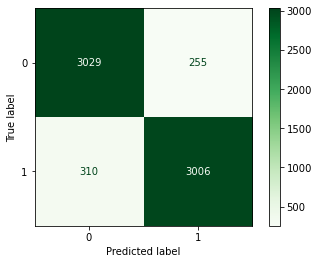

In [63]:
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

## CVEC and RandomForest

In [70]:
pipe = Pipeline([
    ('trans', CountVectorizer()),
    ('model', RandomForestClassifier())
])

pipe_params = {
              'trans__ngram_range': [(1,1),(2,2),(3,3)], # dont go too crazy
              'trans__stop_words': ['english', None],
              'model__n_estimators':[100, 125, 150],
              'model__max_depth': [None,3,4, 5, 6],
              'model__max_features':['auto','log2'],
#               'model__min_samples_splits': [2,3],
              'model__min_samples_leaf':[1,2],
}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 16.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 17.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.6min
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed: 18.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', CountVectorizer()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'model__max_depth': [None, 3, 4, 5, 6],
                         'model__max_features': ['auto', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__n_estimators': [100, 125, 150],
                         'trans__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [71]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__max_depth': None,
  'model__max_features': 'auto',
  'model__min_samples_leaf': 1,
  'model__n_estimators': 125,
  'trans__ngram_range': (1, 1),
  'trans__stop_words': None},
 0.9079850746268658,
 Pipeline(steps=[('trans', CountVectorizer()),
                 ('model', RandomForestClassifier(n_estimators=125))]))

In [72]:
gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test)

(0.9982835820895523, 0.9101515151515152)

Specificity: 0.8867235079171741 Sensitivity: 0.9333534378769602


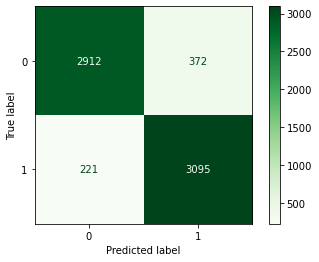

In [73]:
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

## <font color='gold'>TFID and Logreg</font>

---
After running many, many models, I considered this my best one because the test scores stayed relatively high and the train score was not much higher than the test score. It was less than 2% difference so the overfit isn't as bad.

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 4562 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 5312 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 6162 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 7112 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 8162 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 9312 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 10562 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 11912 tasks      | elapsed: 14.3min
[Parallel(n_jobs=4)]: Done 13362 tasks      | elapsed: 16.

0.9373880597014925 0.9216666666666666
Specificity: 0.9232643118148599 Sensitivity: 0.9200844390832328


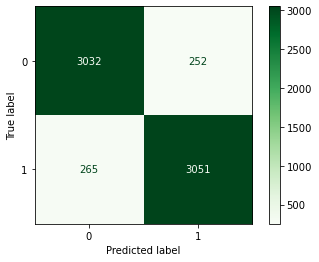

In [85]:
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', LogisticRegression())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000,7000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2'],
              'model__C':[1,.95]}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)
print(gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test))
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

In [86]:
gs.best_params_, gs.best_score_, gs.best_estimator_ # << Pickle the best estimator

({'model__C': 1,
  'model__penalty': 'l2',
  'trans__max_df': 0.85,
  'trans__max_features': 3000,
  'trans__min_df': 5,
  'trans__ngram_range': (1, 3),
  'trans__stop_words': None},
 0.9138805970149255,
 Pipeline(steps=[('trans',
                  TfidfVectorizer(max_df=0.85, max_features=3000, min_df=5,
                                  ngram_range=(1, 3))),
                 ('model', LogisticRegression(C=1))]))

In [87]:
# Make a folder for assets to contain my pickled models
import os

try:
    os.mkdir('assets')
except:
    print('assets folder already exists!')

In [91]:
import pickle
a_model = './assets/best_model.pkl'
# Save the estimators
pickle.dump(gs, open(a_model, 'wb+'))

In [93]:
# Saving the train scores
pickle.dump(gs.score(X_stem_train, y_stem_train), open('./assets/best_train_score.pkl','wb+'))
pickle.dump(gs.score(X_stem_test, y_stem_test), open('./assets/best_test_score.pkl','wb+'))

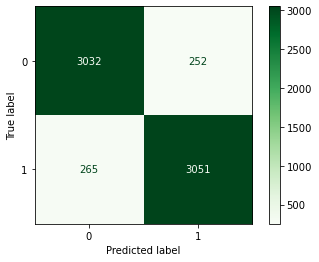

In [96]:
# pickle the plot of the confusion matrix
pickle.dump(plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d'), 
            open('./assets/best_confusionmatrix.pkl','wb+'))

This model differs from the top because I used a StratifiedKfold here rather than up top. This may be an issue since I didn't shuffle the data initially before running a lot of my models. But due to time constraints, I will proceed with the top model to be my best.

In [66]:
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', LogisticRegression())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None],
              'model__penalty': ['l1', 'l2'],
              'model__C':[1,.95]}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 4262 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 5012 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 5862 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 6812 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 7862 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 9012 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 10262 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done 11612 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed: 1

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=4,
             param_grid={'model__C': [1, 0.95], 'model__penalty': ['l1', 'l2'],
                         'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [67]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'model__C': 1,
  'model__penalty': 'l2',
  'trans__max_df': 0.85,
  'trans__max_features': 6000,
  'trans__min_df': 3,
  'trans__ngram_range': (1, 2),
  'trans__stop_words': None},
 0.9144776119402984,
 Pipeline(steps=[('trans',
                  TfidfVectorizer(max_df=0.85, max_features=6000, min_df=3,
                                  ngram_range=(1, 2))),
                 ('model', LogisticRegression(C=1))]))

In [68]:
gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test)

(0.9427611940298507, 0.9225757575757576)

Specificity: 0.925700365408039 Sensitivity: 0.919481302774427


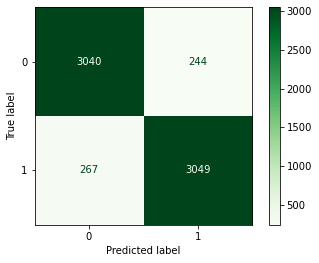

In [69]:
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

## TFID and MultiNB

In [74]:
pipe = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', MultinomialNB())
])

pipe_params = {'trans__max_features': [2000,3000,4000,5000,6000,7000],
              'trans__min_df': [2,3,4,5],
              'trans__max_df': [.85,.9,.95],
              'trans__ngram_range': [(1,1),(1,2),(1,3),(2,2),(3,3)],
              'trans__stop_words': ['english', None, add_words],
               
}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 5400 out of 5400 | elapsed:  6.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=4,
             param_grid={'trans__max_df': [0.85, 0.9, 0.95],
                         'trans__max_features': [2000, 3000, 4000, 5000, 6000,
                                                 7000],
                         'trans__min_df': [2, 3, 4, 5],
                         'trans__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (3, 3)],
                         'trans__stop_words': ['english', None,
                                               ['depression', 'shower thoughts',
                                                'shower', 'thoughts']]},
             verbose=1)

In [75]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'trans__max_df': 0.85,
  'trans__max_features': 7000,
  'trans__min_df': 3,
  'trans__ngram_range': (1, 2),
  'trans__stop_words': None},
 0.9085820895522388,
 Pipeline(steps=[('trans',
                  TfidfVectorizer(max_df=0.85, max_features=7000, min_df=3,
                                  ngram_range=(1, 2))),
                 ('model', MultinomialNB())]))

In [76]:
gs.score(X_stem_train, y_stem_train), gs.score(X_stem_test, y_stem_test)

(0.9351492537313433, 0.9174242424242425)

Specificity: 0.9369671132764921 Sensitivity: 0.8980699638118215


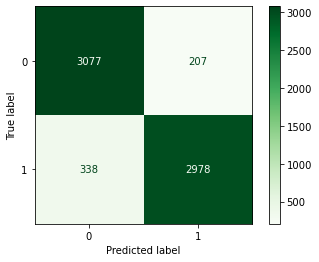

In [77]:
preds = gs.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

# <font color='green'>TFID and RandomForest</font>

---
This is the random forest that I will compare to my best model.

In [97]:
pipe2 = Pipeline([
    ('trans', TfidfVectorizer()),
    ('model', RandomForestClassifier())
])

pipe_params2 = {
              'trans__ngram_range': [(1,1),(2,2),(3,3)], # dont go too crazy
              'trans__stop_words': ['english', None],
              'model__n_estimators':[100, 125, 150],
              'model__max_depth': [None,3,4, 5, 6],
              'model__max_features':['auto','log2'],
#               'model__min_samples_splits': [2,3],
              'model__min_samples_leaf':[1,2],
}

cv_folds = StratifiedKFold(shuffle=True, random_state=66)

gs2 = GridSearchCV(pipe2,
                  pipe_params2,
                  cv = cv_folds, verbose=1, n_jobs=4)

gs2.fit(X_stem_train, y_stem_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 17.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.4min
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed: 18.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=66, shuffle=True),
             estimator=Pipeline(steps=[('trans', TfidfVectorizer()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'model__max_depth': [None, 3, 4, 5, 6],
                         'model__max_features': ['auto', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__n_estimators': [100, 125, 150],
                         'trans__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'trans__stop_words': ['english', None]},
             verbose=1)

In [98]:
gs2.best_params_, gs2.best_score_, gs2.best_estimator_

({'model__max_depth': None,
  'model__max_features': 'log2',
  'model__min_samples_leaf': 1,
  'model__n_estimators': 150,
  'trans__ngram_range': (1, 1),
  'trans__stop_words': None},
 0.9120149253731343,
 Pipeline(steps=[('trans', TfidfVectorizer()),
                 ('model',
                  RandomForestClassifier(max_features='log2',
                                         n_estimators=150))]))

In [99]:
gs2.score(X_stem_train, y_stem_train), gs2.score(X_stem_test, y_stem_test)

(0.9982089552238806, 0.9168181818181819)

Specificity: 0.8982947624847747 Sensitivity: 0.9351628468033776


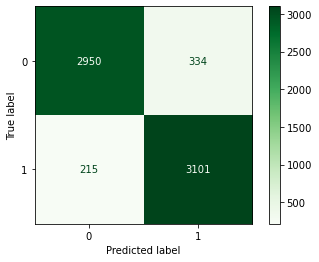

In [100]:
preds = gs2.predict(X_stem_test)
tn, fp, fn, tp = confusion_matrix(y_stem_test, preds).ravel()
plot_confusion_matrix(gs2, X_stem_test, y_stem_test, cmap='Greens', values_format='d');

# Specificity
spec = tn / (tn + fp)
# Sensitivity
sen = tp / (tp + fn)
print("Specificity:", spec, "Sensitivity:", sen)

I will pickle these results as well.

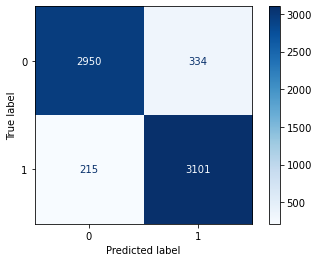

In [101]:
# pickle model
pickle.dump(gs2, open('./assets/forest_model.pkl', 'wb+'))
# pickle confusion matrix
pickle.dump(plot_confusion_matrix(gs2, X_stem_test, y_stem_test, cmap='Blues', values_format='d'), 
            open('./assets/forest_confusionmatrix.pkl','wb+'))
# pickle train and test score
pickle.dump(gs2.score(X_stem_train, y_stem_train), open('./assets/forest_train_score.pkl','wb+'))
pickle.dump(gs2.score(X_stem_test, y_stem_test), open('./assets/forest_test_score.pkl','wb+'))

### End of modeling

--- 
Could I have done more? Sure, however, due to time constraints it ends here. **I felt sufficient with what I have accomplished thus far.**

In [107]:
# Pickle the test stem models
X_stem_test.head()

1132     ['the', 'most', 'futurist', 'thing', 'about', ...
5661     ['if', 'ʇıppǝɹ', 'analyz', 'the', 'person', 'a...
7368     ['all', 'meme', 'are', 'nsfw', 'becaus', 'you'...
1806                              ['make', 'you', 'think']
19737    ['what', 'deal', 'with', 'depress', 'alon', 'f...
Name: pstem_words, dtype: object

In [108]:
y_stem_test.head()

1132     0
5661     0
7368     0
1806     0
19737    1
Name: subreddit, dtype: int64

In [109]:
pickle.dump(X_stem_test, open('./assets/X_stem_test.pkl', 'wb+'))
pickle.dump(y_stem_test, open('./assets/y_stem_test.pkl', 'wb+'))